In [7]:
import numpy as np, pandas as pd, scanpy as sc, anndata as ad, matplotlib.pyplot as plt, os, logging, seaborn as sns, pickle
from scipy.stats import median_abs_deviation, hypergeom
import multiprocessing as mp, celloracle as co
from tqdm import tqdm
from celloracle.applications import Gradient_calculator
from celloracle.applications import Oracle_development_module

# visualization settings required to see plots in jupyter notebook
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

wd = '/ocean/projects/cis240075p/skeshari/igvf/bcell2/male_donor/'
out_path = os.path.join(wd, 'out_data', 'co_analysis_1')
os.makedirs(f"{out_path}/figures", exist_ok=True)
os.makedirs(f"{out_path}/intermediate_data", exist_ok=True)
os.makedirs(f"{out_path}/out_files", exist_ok=True)
os.makedirs(f"{out_path}/scripts", exist_ok=True)
sc.settings.figdir = f"{out_path}/figures"

In [2]:
CONFIG = {"default_args": {"lw": 0.3, "rasterized": True},
          "s_scatter": 5,
          "s_grid": 20,
          "scale_simulation": 30,
          "scale_dev": 30,
          "cmap_ps": "PiYG",
          "default_args_quiver": {"linewidths": 0.25, "width": 0.004}}

def _plot_quiver(oracle, ax=None, scale=CONFIG["scale_simulation"], color=None, s=CONFIG["s_scatter"], show_background=True, args=CONFIG["default_args"], data_random=False):

    if ax is None:
        ax = plt

    if not hasattr(oracle, "cell_idx_use"):
        oracle.cell_idx_use = None

    if oracle.cell_idx_use is None:
        ix_choice = np.arange(oracle.embedding.shape[0])
    else:
        ix_choice = oracle.cell_idx_use

    # Plot whole cell with lightgray
    if show_background:
        ax.scatter(oracle.embedding[:, 0], oracle.embedding[:, 1],
                   c="lightgray", alpha=1, s=s, **args)


    ax.scatter(oracle.embedding[ix_choice, 0], oracle.embedding[ix_choice, 1],
               c="lightgray", alpha=0.2, edgecolor=(0,0,0,1), s=s, **args)



    if color is None:
        color=oracle.colorandum[ix_choice]

    quiver_kwargs=dict(headaxislength=7, headlength=11, headwidth=8,
                       linewidths=0.25, width=0.0045,edgecolors="k",
                       color=color, alpha=1)

    if data_random:
        quiver = oracle.delta_embedding_random
    else:
        quiver = oracle.delta_embedding

    ax.quiver(oracle.embedding[ix_choice, 0], oracle.embedding[ix_choice, 1],
              quiver[ix_choice, 0],
              quiver[ix_choice, 1],
              scale=scale, **quiver_kwargs)

    ax.axis("off")


In [4]:
oracle = co.load_hdf5(f"{wd}/out_data/co_analysis/intermediate_data/oracle_fitted.celloracle.oracle")
stream_xdr = pd.read_csv(f"{wd}/out_data/out_other_methods/stream_xdr.csv", index_col=0)

FileNotFoundError: [Errno 2] No such file or directory: '/ocean/projects/cis240075p/skeshari/igvf/bcell2/male_donor//out_data/out_other_methods/stream_xdr.csv'

Simulating perturbation for PRDM1
Estimating transition probability for PRDM1
Calculating embedding for PRDM1


2024-12-17 14:39:33,297 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-12-17 14:39:33,312 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


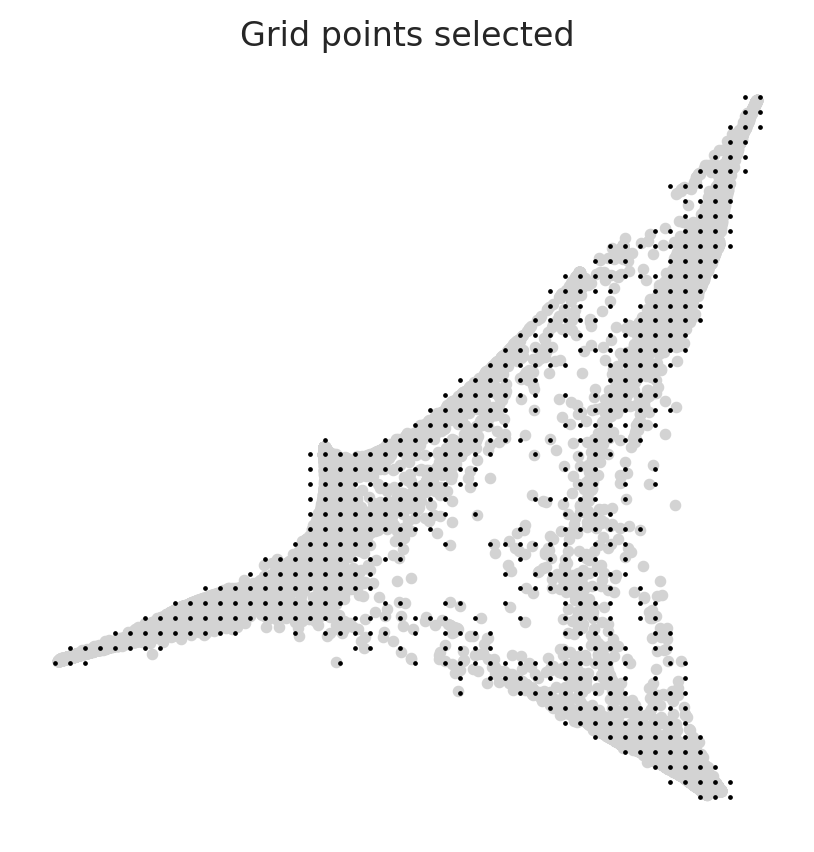

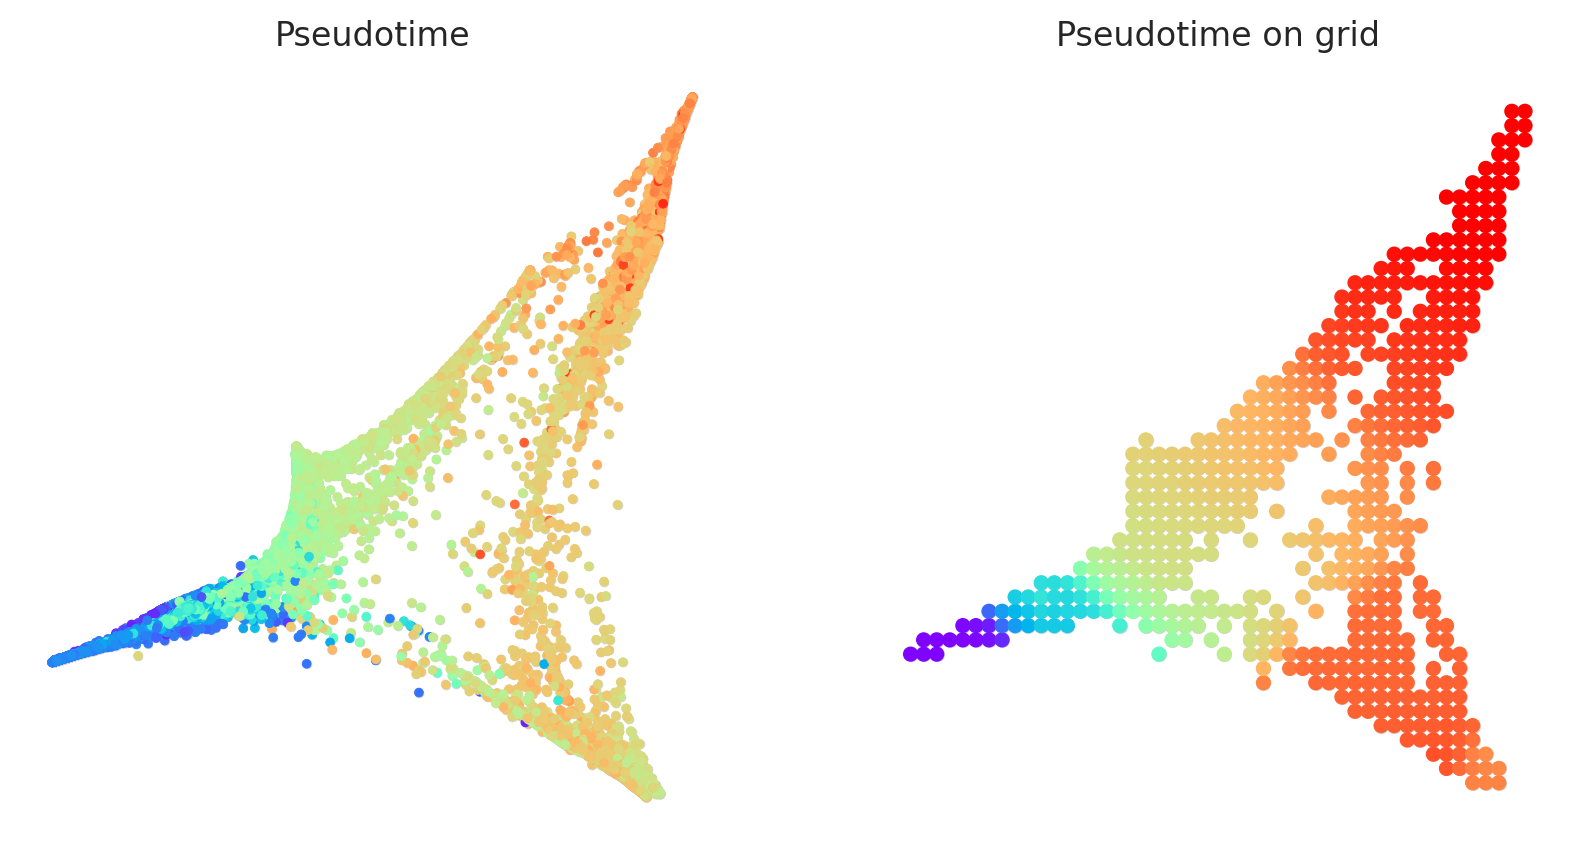

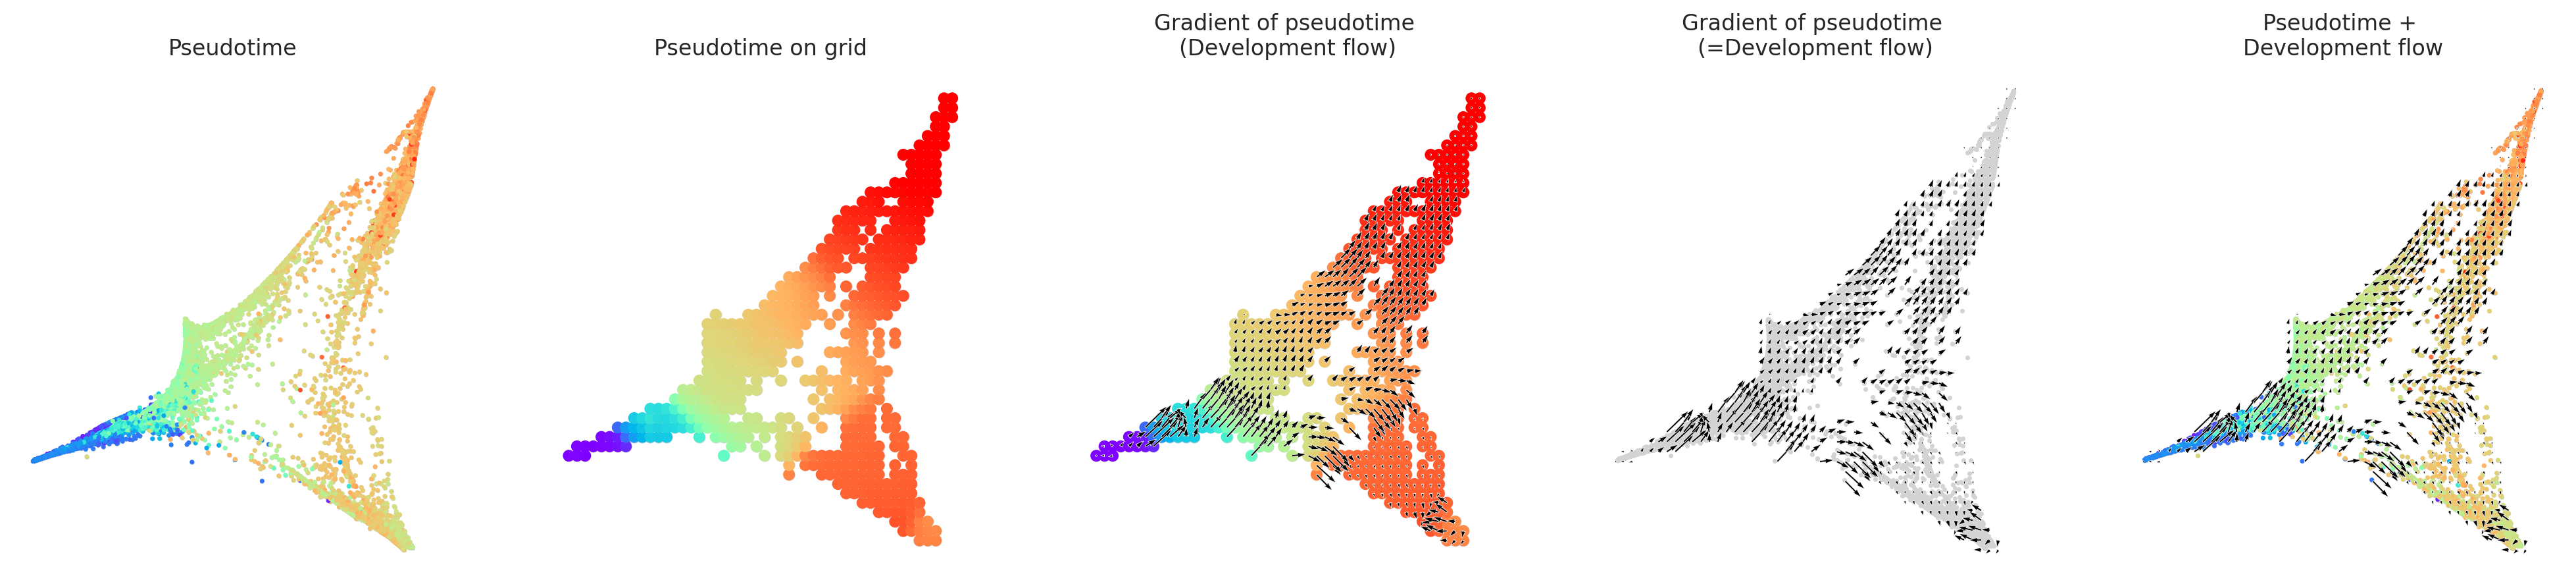

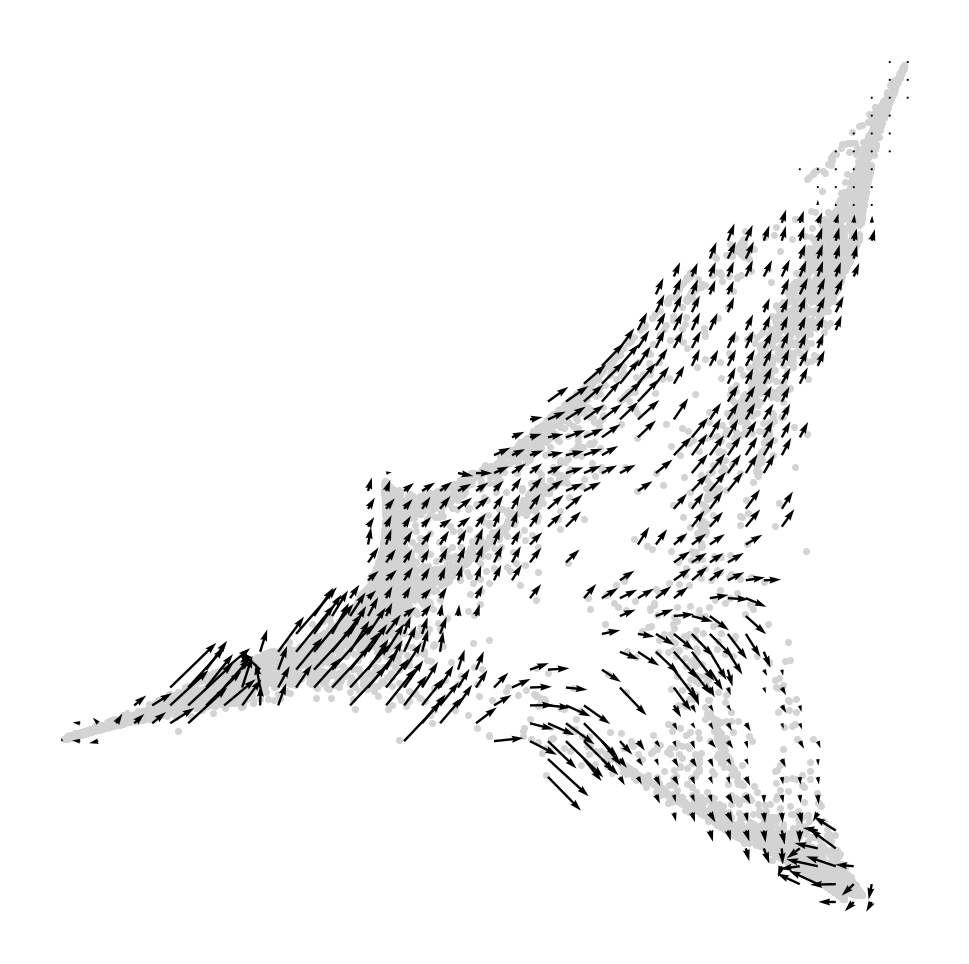

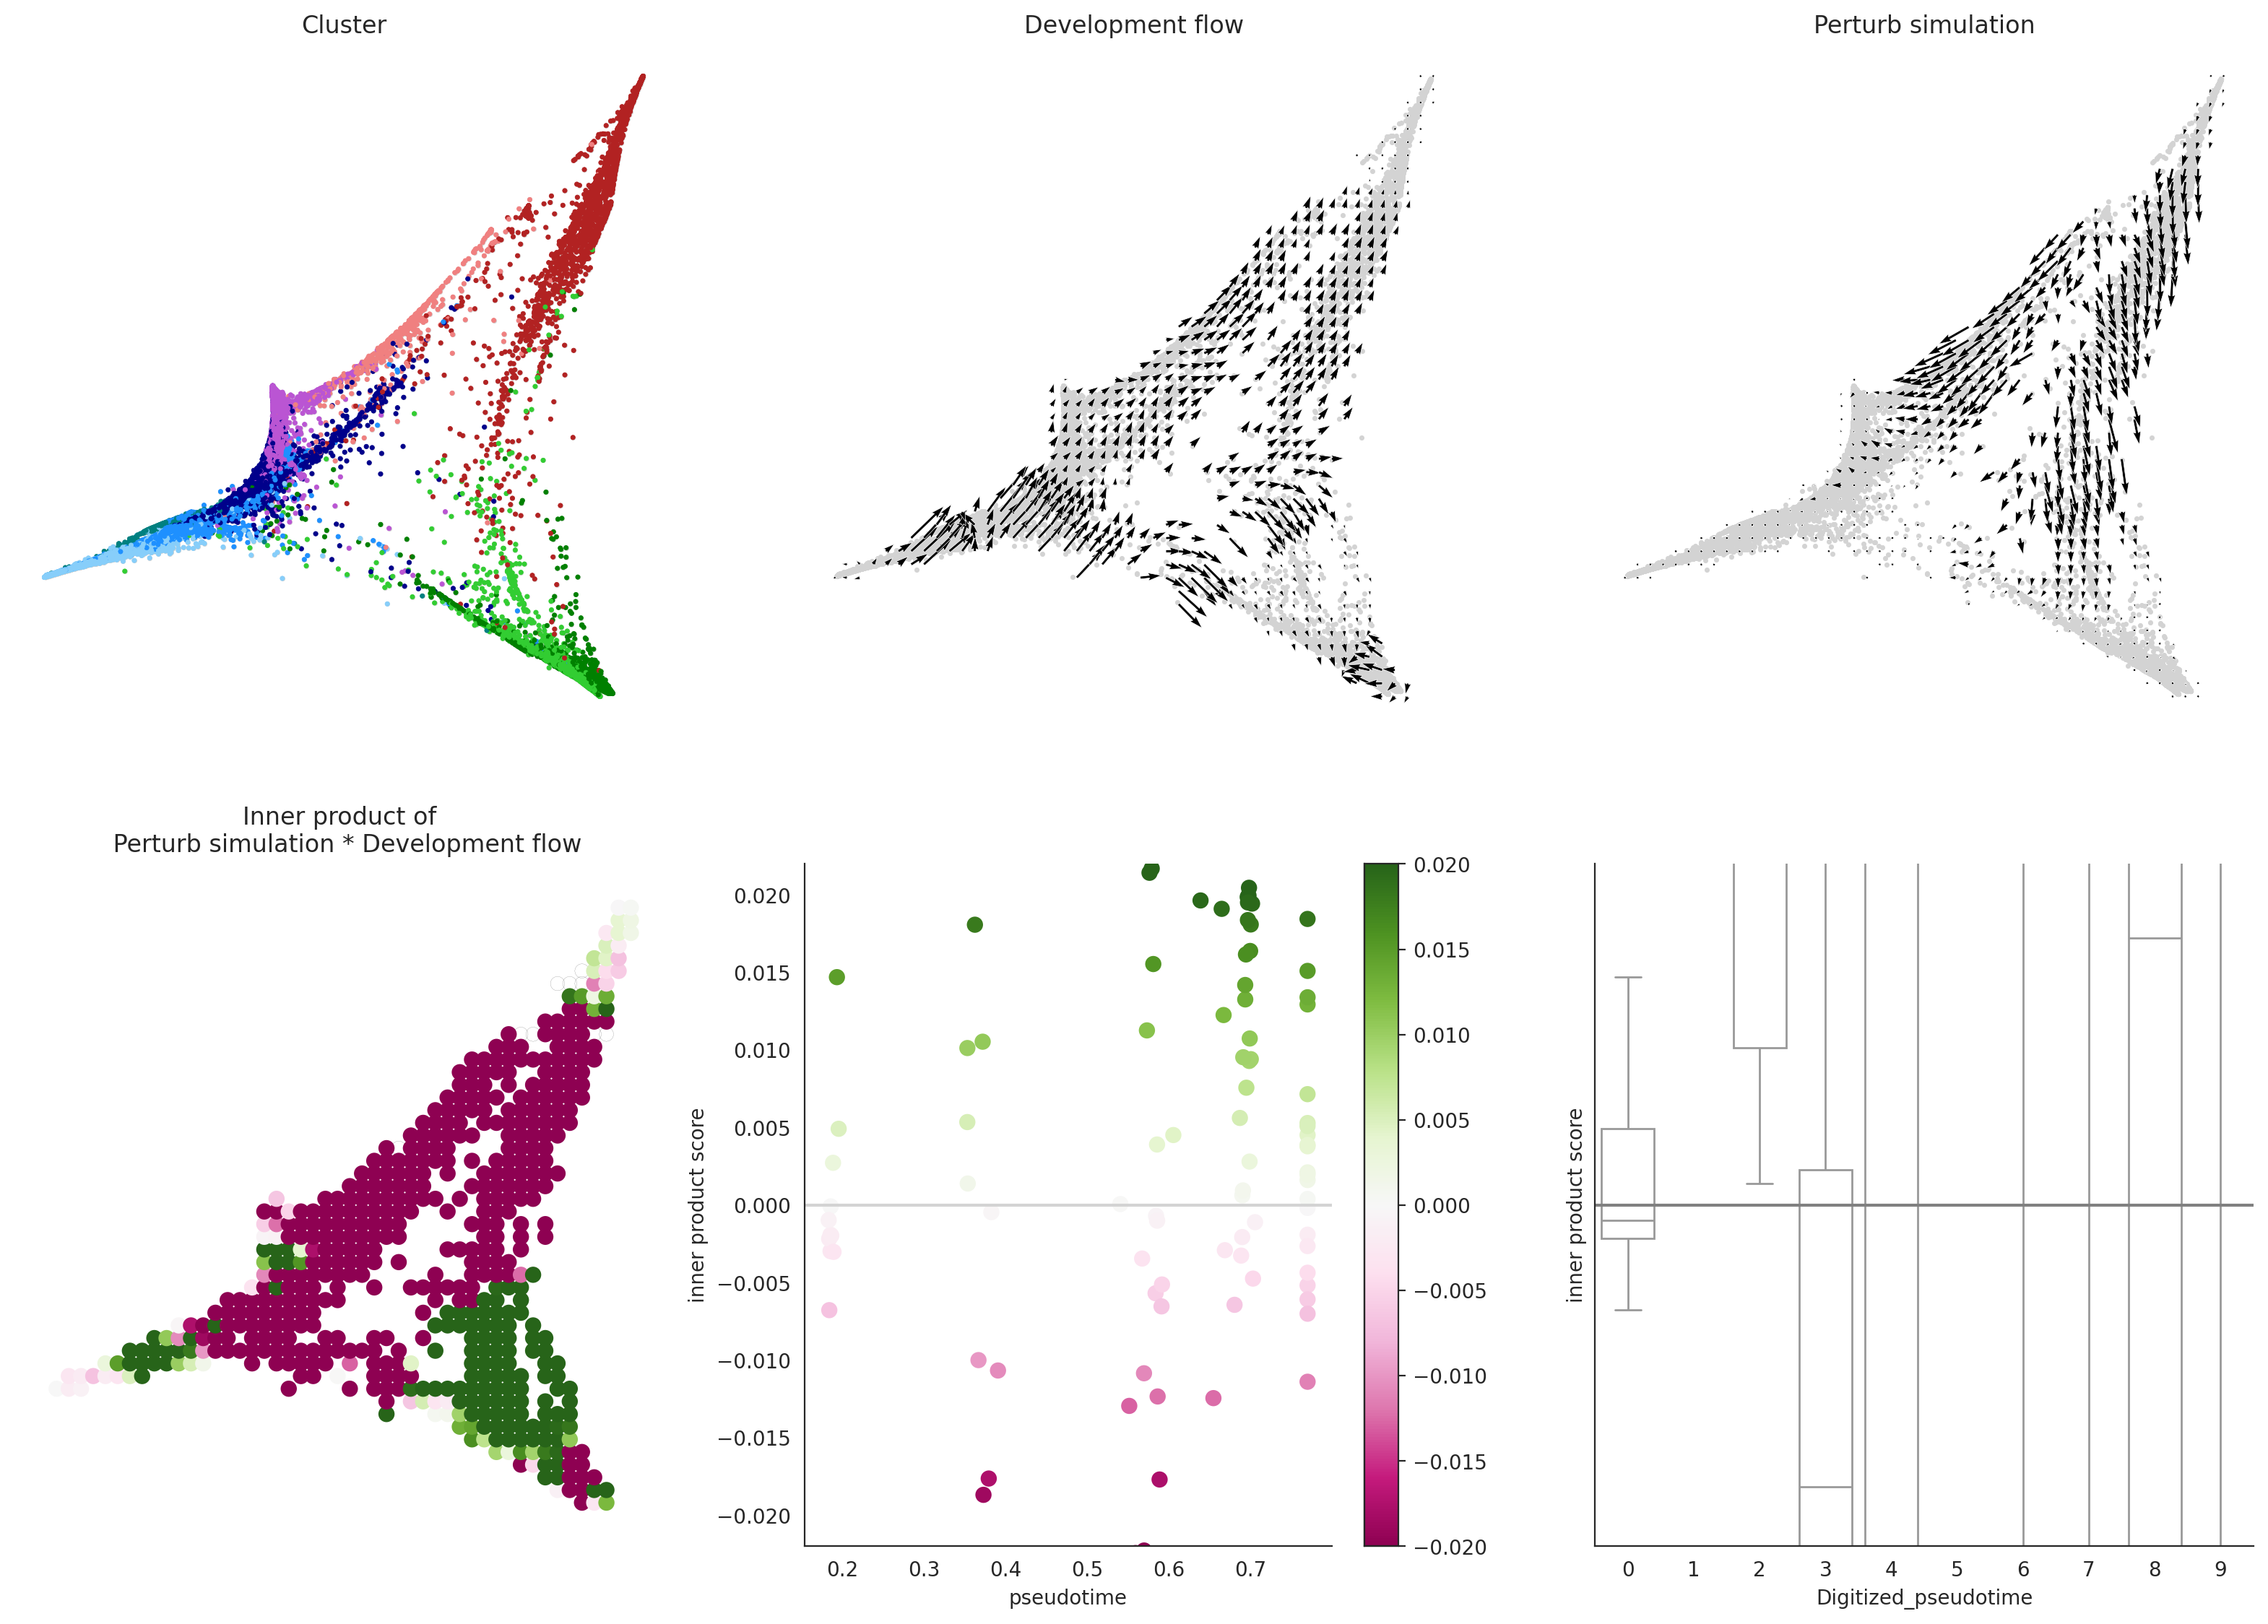

In [57]:
matching_indices = oracle.adata.obs_names.isin(stream_xdr.index)
oracle.adata.obsm['X_umap'][matching_indices] = stream_xdr.loc[oracle.adata.obs_names[matching_indices]].values
oracle.adata = oracle.adata[matching_indices]
oracle.colorandum = oracle.colorandum[matching_indices]

score_dict = {}
# tf_of_interest = ['BATF', 'BATF3', 'BCL6', 'EGR1', 'FOS', 'IKZF1', 'IRF1', 'IRF4', 'IRF8', 'JUNB', 'JUND', 'MEF2A', 'MEF2C', 'MYB', 'NFATC1', 'NTC1', 'NFATC2', 'NFIL3', 'NFKB1', 'NFKB2', 'PAX5', 'PRDM1', 'RUNX1', 'SP3', 'SPI1', 'STAT1', 'STAT5A', 'TCF12', 'VDR', 'XBP1', 'ZBTB7A', 'SPIB']
scale_simulation=15
n_grid=40
min_mass=3
goi = 'PRDM1'
print(f'Simulating perturbation for {goi}', flush=True)
oracle.simulate_shift(perturb_condition={goi: 0.0},n_propagation=1) # If kernal crashes increase the memory limit of jupyter notebook
print(f'Estimating transition probability for {goi}', flush=True)
oracle.estimate_transition_prob(n_neighbors=1000, knn_random=True, sampled_fraction=1) # Get transition probability
print(f'Calculating embedding for {goi}', flush=True)
oracle.calculate_embedding_shift(sigma_corr=0.05) # Calculate embedding

n_grid=50
min_mass=5000
gradient = Gradient_calculator(oracle_object=oracle, pseudotime_key="dpt_pseudotime")
gradient.calculate_p_mass(smooth=0.3, n_grid=n_grid, n_neighbors=20)
gradient.calculate_mass_filter(min_mass=min_mass, plot=True)

gradient.transfer_data_into_grid(args={"method": "knn", "n_knn":2000}, plot=True)
gradient.calculate_gradient()
scale_dev = 50
gradient.visualize_results(scale=scale_dev, s=5)
fig, ax = plt.subplots(figsize=[6, 6])
gradient.plot_dev_flow_on_grid(scale=scale_dev, ax=ax)

dev = Oracle_development_module()
# Load development flow
dev.load_differentiation_reference_data(gradient_object=gradient)
# Load simulation result
dev.load_perturb_simulation_data(oracle_object=oracle, 
                                #  cell_idx_use=cell_idx, # Enter cell id list
                                name=f"{goi}" # Name of this cell group. You can enter any name.
                                )

# Calculation
dev.calculate_inner_product()
dev.calculate_digitized_ip(n_bins=10)
# Let's visualize the results 
vm = 0.02
dev.visualize_development_module_layout_0(s=5, 
                                        scale_for_simulation=scale_simulation,
                                        s_grid=50,
                                        scale_for_pseudotime=scale_dev, 
                                        vm=vm)
plt.savefig(f"{out_path}/figures/{goi}_perturbation_score.pdf", dpi=300)

In [58]:
day = 'D2'
cell_bc = pd.read_csv(f"{wd}/out_data/out_other_methods/predisposed_cells/{day}/{day}_per_{goi}.csv",header=0)
row_dot_product = np.einsum('ij,ij->i', oracle.delta_embedding, gradient.embedding)
pct_75_abc = row_dot_product[(oracle.adata.obs['leiden'] =='ActB-4') & (~(oracle.adata.obs.index.isin((cell_bc['Unnamed: 0']))))]
pct_25_abc = row_dot_product[(oracle.adata.obs.index.isin((cell_bc['Unnamed: 0'])))]
pct_75_abc = pct_75_abc[~np.isnan(pct_75_abc)]
pct_25_abc = pct_25_abc[~np.isnan(pct_25_abc)]

neg_75_abc = np.mean(pct_75_abc[pct_75_abc < 0])
neg_25_abc = np.mean(pct_25_abc[pct_25_abc < 0])
pos_75_abc = np.mean(pct_75_abc[pct_75_abc > 0])
pos_25_abc = np.mean(pct_25_abc[pct_25_abc > 0])  

score_dict[goi] = {'pct_75_abc': pct_75_abc, 'pct_25_abc': pct_25_abc, 'pct_75_abc_len': len(pct_75_abc), 'pct_25_abc_len': len(pct_25_abc), 'pb_neg_ps': pb_neg_ps, 'gc_neg_ps': gc_neg_ps, 'pb_pos_ps': pb_pos_ps, 'gc_pos_ps': gc_pos_ps}


In [60]:
neg_75_abc, neg_25_abc, pos_75_abc, pos_25_abc

(-3.8978349945352696e-05,
 -2.5751792490340266e-05,
 2.8239834816116512e-05,
 2.452556073542596e-05)

In [48]:
(gc_neg_ps/gc_pos_ps) , (pb_neg_ps/pb_pos_ps)

(-0.43370943903118214, -0.4492183970964185)

In [23]:
score_dict[goi]

{'pb_score': array([-7.96387294e-06,  1.22701715e-05,  7.12268271e-05, ...,
         1.19859768e-04,  1.53647799e-05,  3.61031477e-05]),
 'gc_score': array([-7.96387294e-06,  1.22701715e-05,  7.12268271e-05, ...,
         1.19859768e-04,  1.53647799e-05,  3.61031477e-05]),
 'pb_score_len': 1219,
 'gc_score_len': 1219,
 'pb_neg_ps': 371,
 'gc_neg_ps': 371,
 'pb_pos_ps': 848,
 'gc_pos_ps': 848}

In [5]:
gois = ['BATF','IRF4','IRF8','SPIB','PRDM1']
days = ['D2','D4']
for day in days:    
    for goi in tqdm(gois):
        cell_bc = pd.read_csv(f"{wd}/out_data/out_other_methods/predisposed_cells/{day}/{day}_per_{goi}.csv",header=0)
        oracle = co.load_hdf5(f"{out_path}/out_files/{goi}_perturbation.celloracle.oracle")
        fig, ax = plt.subplots(1, 2,  figsize=[13, 6])
        scale = 25
        oracle.cell_idx_use = oracle.adata.obs.index.isin((cell_bc['Unnamed: 0']))
        # Show quiver plot
        _plot_quiver(oracle = oracle, scale=scale, ax=ax[0])
        ax[0].set_title(f"Simulated cell identity shift vector: {goi} KO")
        # Show quiver plot that was calculated with randomized graph.
        _plot_quiver(oracle = oracle, scale=scale, ax=ax[1], data_random = True)
        ax[1].set_title(f"Randomized simulation vector")
        plt.savefig(f"{out_path}/figures/{day}_{goi}_perturbation_cell.pdf")
        plt.close()
        # clear memory
        del oracle

100%|██████████| 5/5 [18:47<00:00, 225.54s/it]
